In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# Oświadczam, że zadanie zostało wykonane samodzielnie

import os

from collections import OrderedDict
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import csv


def load_dataset(file):
    df = pd.read_csv(os.path.join('drive', 'My Drive', 'nlp-classes', 'project', 'dataset', file), sep='	', usecols=['gold_label', 'sentence1', 'sentence2'])
    return df.loc[df['gold_label'] != '-'], df.loc[df['gold_label'] == '-']


def _load_embeddings(snli_words, embeddings_dim=200):
    with open(os.path.join('drive', 'My Drive', 'nlp-classes', 'project', 'dataset', 'word_vectors.txt'), encoding='utf8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=' ', quoting=csv.QUOTE_NONE)
        snli_words_set = set(snli_words)
        embeddings = OrderedDict()
        embeddings['<pad>'] = np.random.randint(0, 2, embeddings_dim)
        embeddings['<bos>'] = np.random.randint(0, 2, embeddings_dim)
        embeddings['<eos>'] = np.random.randint(0, 2, embeddings_dim)
        embeddings['<unk>'] = np.random.randint(0, 2, embeddings_dim)
        for row in csv_reader:
            word = row[0]
            if word in snli_words_set:
                embeddings[word] = np.array(row[1:], dtype=float)
        return embeddings


def _get_unk(sent, embeddings):
    return [word for word in sent.split() if word not in embeddings]


def _tokenize_sentences(df):
    df_copy = df.copy()
    df_copy['sentence1'] = df_copy['sentence1'].map(
        lambda s: np.array(['<bos>'] + word_tokenize(s.lower()) + ['<eos>']))
    df_copy['sentence2'] = df_copy['sentence2'].map(
        lambda s: np.array(['<bos>'] + word_tokenize(s.lower()) + ['<eos>']))
    return df_copy


def _get_snli_words(df):
    all_sent = pd.concat([df['sentence1'], df['sentence2']])
    words = set()
    for sent in all_sent:
        words |= set(sent)
    return words


def _map_unks(sentences, unks):
    sentences['sentence1'] = sentences['sentence1'].map(
        lambda l: np.array([x if x not in unks else '<unk>' for x in l]))
    sentences['sentence2'] = sentences['sentence2'].map(
        lambda l: np.array([x if x not in unks else '<unk>' for x in l]))
    return sentences


def prepare_dataset(file, verbose=False):
    clear, unclear = load_dataset(file)
    if verbose:
        display(unclear.head(10))
    sentences = _tokenize_sentences(clear)
    snli_words = _get_snli_words(sentences)
    embeddings = _load_embeddings(snli_words)
    unks = snli_words - embeddings.keys()
    if verbose:
        print(f'All words count (unique): {len(snli_words)}')
        print(f'Unknown count (unique): {len(unks)}')
    prepared = _map_unks(sentences, unks)
    return prepared, embeddings

tr_set, tr_emb = prepare_dataset('train.txt', verbose=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,gold_label,sentence1,sentence2
156,-,A woman wearing a pink hat is looking at a pin...,The woman is wearing clothes.
518,-,A man in a white jacket standing in front of a...,The man was playing crochet with the two women.
1250,-,A man with red earphones is working on a red a...,A man in earphones is fixing a broken hotrod.
2082,-,A boy and a girl are walking in a mall.,A girl and a boy walking inside
2186,-,A man with sunglasses on his head is standing ...,A guy and his pets are waiting by the terminal.
2367,-,People relaxing under green umbrella's with a ...,The folk is hiding from the sun under green um...
2995,-,The girl in the pink top is riding a skateboar...,The girl is skateboarding outside.
3220,-,A man is carving a large eagle out of wood in ...,The man is an artist.
3677,-,Men and women wearing white swim caps giving e...,Men and women joking around.
4357,-,A old man in a green shirt sits on the curb ho...,An old man holds a digital camera and sits on ...


All words count (unique): 22567
Unknown count (unique): 3178


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
tr_set, tr_emb = prepare_dataset('train.txt')
val_set, val_emb = prepare_dataset('dev.txt')

In [ ]:
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import datetime


def get_words_mapping(embeddings):
    word2idx = {key: i for i, key in enumerate(embeddings.keys())}
    idx2word = {i: key for i, key in enumerate(embeddings.keys())}
    return word2idx, idx2word


def get_embeddings_tensor(embeddings):
    return torch.Tensor(list(embeddings.values())).cuda()


class NaturalLanguageInference(nn.Module):

    def __init__(self, lstm_hidden_dim, embeddings, fully_connected_hidden_dim, embedding_dim=200, out_dim=3,
                 batch_size=32):
        super(NaturalLanguageInference, self).__init__()
        self.batch_size = batch_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_hidden = self.init_hidden()
        self.out_dim = out_dim
        self.fully_connected_hidden_dim = fully_connected_hidden_dim
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        embeddings_tensor = get_embeddings_tensor(embeddings)
        self.embeddings = nn.Embedding.from_pretrained(embeddings=embeddings_tensor)
        self.word2idx, self.idx2word = get_words_mapping(embeddings)
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, batch_first=True).cuda()
        self.fully_connected = nn.Sequential(nn.Linear(2 * self.embedding_dim, self.fully_connected_hidden_dim),
                                             nn.ReLU(),
                                             nn.Linear(self.fully_connected_hidden_dim, self.out_dim),
                                             nn.LogSoftmax(dim=1)).cuda()

    def init_hidden(self):
        return Variable(torch.zeros(1, self.batch_size, self.lstm_hidden_dim).cuda()), Variable(torch.zeros(1, self.batch_size, self.lstm_hidden_dim).cuda())

    def forward(self, batch_sent1, batch_sent2):
        self.lstm_hidden = self.init_hidden()
        batch1_tensor, batch2_tensor = self.get_batch_embedding(pd.concat([batch_sent1, batch_sent2], ignore_index=True))
        lstm1, _ = self.lstm(batch1_tensor, self.lstm_hidden)
        lstm2, _ = self.lstm(batch2_tensor, self.lstm_hidden)
        lstm_out_concat = torch.cat((lstm1[:, -1, :], lstm2[:, -1, :]), 1).cuda()
        return self.fully_connected(lstm_out_concat)

    def get_batch_embedding(self, batch_sent):
        tensors = []
        for i, sent in enumerate(batch_sent.values):
            sent_emb = [self.embeddings(torch.LongTensor([self.word2idx.get(word, 3)]).cuda()) for word in sent]
            tensors.append(torch.stack(sent_emb).cuda())
        padded = nn.utils.rnn.pad_sequence(tensors, batch_first=True).view(len(batch_sent), -1, self.embedding_dim).cuda()
        return padded[:self.batch_size].cuda(), padded[self.batch_size:].cuda()


def batched(data, batch_size=32, seed=43):
    rng = np.random.RandomState(seed=seed)
    indexes = rng.choice(len(data), size=batch_size, replace=False)
    return data.iloc[indexes]

def score(pred_probs, actual):
    pred = torch.argmax(pred_probs, dim=1)
    return torch.sum(actual == pred).sum().item() / len(actual)

def save_model(model, file):
  torch.save(model.state_dict(), os.path.join('drive', 'My Drive', 'nlp-classes', 'project', file))
  
def load_model(file):
  return torch.load(os.path.join('drive', 'My Drive', 'nlp-classes', 'project', file))

out2idx = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
idx2out = {0: 'neutral', 1: 'contradiction', 2: 'entailment'}

MAX_EPOCHS = 5
BATCH_SIZE = 32
TRAINING_LEN = len(tr_set)
VAL_LEN = len(val_set)


In [ ]:
import time
model = NaturalLanguageInference(lstm_hidden_dim=200, embeddings=tr_emb, fully_connected_hidden_dim=200, batch_size=BATCH_SIZE).cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

best_score = -1
scores_per_epoch = []
losses_on_training_per_epoch = []
losses_on_test_per_epoch = []
print(f'Iters per epoch: {TRAINING_LEN // BATCH_SIZE}')
for epoch in range(MAX_EPOCHS):
    print(f'{datetime.datetime.now()} Starting epoch {epoch}')
    loss_on_training_per_epoch = 0
    for iteration in range(TRAINING_LEN // BATCH_SIZE):
#         print(f'\tIteration: {iteration}')
        model.zero_grad()

        batch = batched(tr_set, batch_size=BATCH_SIZE, seed=int(round(time.time() * 1000)) % (2**32 - 1))
        sent1_batch = batch['sentence1']
        sent2_batch = batch['sentence2']
        out = np.array([out2idx[gold_label] for gold_label in batch['gold_label']])
        log_probs = model(sent1_batch, sent2_batch)
        target = torch.LongTensor(out).cuda()
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        loss_on_training_per_epoch += loss.item()
        gc.collect()
    losses_on_training_per_epoch.append(loss_on_training_per_epoch)
    print('\tTraining phase ended')
    with torch.no_grad():
        scores = []
        loss_on_test_per_epoch = 0
        for _ in range(VAL_LEN // BATCH_SIZE):
            val_batch = batched(val_set, seed=int(round(time.time() * 1000)) % (2**32 - 1))
            sent1_val_batch = val_batch['sentence1']
            sent2_val_batch = val_batch['sentence2']
            val_out = np.array([out2idx[gold_label] for gold_label in val_batch['gold_label']])
            log_probs = model(sent1_val_batch, sent2_val_batch)
            val_target = torch.LongTensor(val_out).cuda()
            loss = loss_function(log_probs, val_target).item()
            loss_on_test_per_epoch += loss
            scores.append(score(log_probs, val_out))
            gc.collect()
        acc = np.mean(scores)
        losses_on_test_per_epoch.append(loss_on_test_per_epoch)
        scores_per_epoch.append(acc)
        save_model(model, f'model_epoch{epoch}')
        print(f'\tLoss on training on epoch {epoch}: {loss_on_training_per_epoch / TRAINING_LEN}')
        print(f'\tLoss on test on epoch {epoch}: {loss_on_test_per_epoch / VAL_LEN}')
        print(f'\tAccuracy on epoch {epoch}: {acc}')

Iters per epoch: 3433
2019-01-25 12:52:46.405694 Starting epoch 0
	Training phase ended
	Loss on training on epoch 0: 0.032122889385413314
	Loss on test on epoch 0: 0.029006593282134084
	Accuracy on epoch 0: 0.5632125407166124
2019-01-25 13:02:21.934766 Starting epoch 1
	Training phase ended
	Loss on training on epoch 1: 0.026176650243148483
	Loss on test on epoch 1: 0.025227563964039107
	Accuracy on epoch 1: 0.6375203583061889
2019-01-25 13:11:56.336838 Starting epoch 2
	Training phase ended
	Loss on training on epoch 2: 0.023366152284290034
	Loss on test on epoch 2: 0.0252936306407456
	Accuracy on epoch 2: 0.6374185667752443
2019-01-25 13:21:32.470279 Starting epoch 3
	Training phase ended
	Loss on training on epoch 3: 0.021584272947504278
	Loss on test on epoch 3: 0.025618222780378824
	Accuracy on epoch 3: 0.6482084690553745
2019-01-25 13:31:21.644951 Starting epoch 4
	Training phase ended
	Loss on training on epoch 4: 0.019891523962081985
	Loss on test on epoch 4: 0.025103861082620

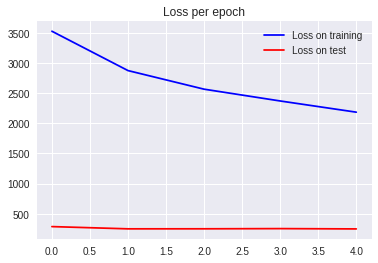

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

scores_per_epoch = np.array(scores_per_epoch)
losses_on_training_per_epoch = np.array(losses_on_training_per_epoch)
losses_on_test_per_epoch = np.array(losses_on_test_per_epoch)

plt.plot(losses_on_training_per_epoch, 'b-', label='Loss on training')
plt.plot(losses_on_test_per_epoch, 'r-', label='Loss on test')
plt.legend()
plt.title('Loss per epoch')
plt.show()

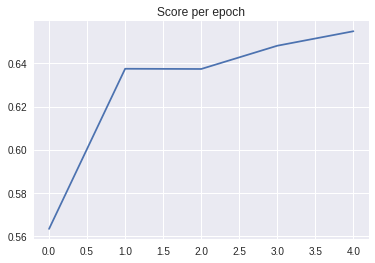

In [ ]:
plt.plot(scores_per_epoch)
plt.title('Score per epoch')
plt.show()

In [ ]:
loaded_model = NaturalLanguageInference(lstm_hidden_dim=200, embeddings=tr_emb, fully_connected_hidden_dim=200, batch_size=BATCH_SIZE).cuda()
loaded_model.load_state_dict(torch.load(os.path.join('drive', 'My Drive', 'nlp-classes', 'project', 'model_epoch4')))
loaded_model.eval()

NaturalLanguageInference(
  (embeddings): Embedding(19391, 200)
  (lstm): LSTM(200, 200, batch_first=True)
  (fully_connected): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=3, bias=True)
    (3): LogSoftmax()
  )
)

In [ ]:
test_set, test_emb = prepare_dataset('test.txt')

In [ ]:
TEST_LEN = len(test_set)
with torch.no_grad():
    scores = []
    for _ in range(TEST_LEN // BATCH_SIZE):
        test_batch = batched(test_set, seed=int(round(time.time() * 1000)) % (2**32 - 1))
#         display(test_batch)
        sent1_test_batch = test_batch['sentence1']
        sent2_test_batch = test_batch['sentence2']
        test_out = np.array([out2idx[gold_label] for gold_label in test_batch['gold_label']])
        log_probs = loaded_model(sent1_test_batch, sent2_test_batch)
        test_target = torch.LongTensor(test_out).cuda()
        loss = loss_function(log_probs, test_target)
        scores.append(score(log_probs, test_target))
        gc.collect()
    acc = np.mean(scores)
    print(f'Accuracy on test: {acc}')


Accuracy on test: 0.6614413680781759
